# CS 109A/AC 209A/STAT 121A Data Science: Homework 7
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [20]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
from sklearn import discriminant_analysis as da
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.tree import export_graphviz

import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Wheelahan, Christopher

### Part (b): Course Number

AC209a

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.


### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise. 

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

- Suppose we were asked to write a computer program to automatically identify the vegetation regions on the landscape. How can we use the model fitting algorithms you have studied so far to identify the boundaries of the vegetation regions? In particular, discuss the suitability of the following algorithms for each of the four data sets (**you do not need to evaluate your classifier, build your argument using data and decision boundary visualizations**): 
    - linear or polynomial linear regression
    - linear or polynomial logistic regression
    - linear or quadratic discriminant analysis
    - decision trees

- By a quick visual inspection of each data set, what do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case? Does `sklearn`'s decision tree fitting algorithm always provide a good fit for the proposed depth? If not, explain why. **Support your answer with suitable visualization**.

We provide you with a function `plot_tree_boundary` to visualize a decision tree model on the data set.

In [9]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (array of predictors)
#      y (array of labels)
#      model (the decision tree you want to visualize, already fitted)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

## Import and visualize the data.

This is an interesting question - essentially what we have is a classification problem where where our inputs are latitude and longitude and our output is a binary "vegetation or not" variable. We know a few methods to approach a question like that, but let's see what kind of data we're working with first.

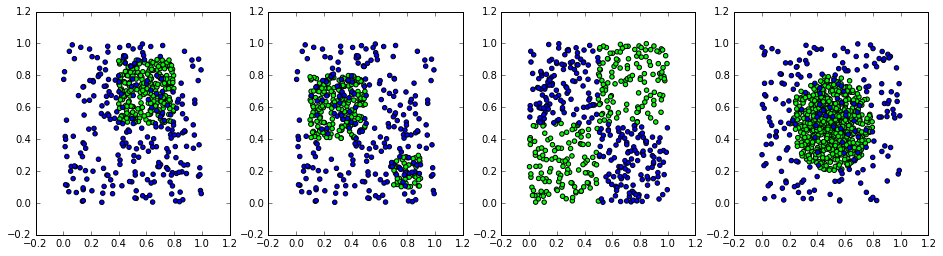

In [10]:
img_1 = pd.read_csv('datasets/dataset_1.txt', delimiter=',', header=None)
img_2 = pd.read_csv('datasets/dataset_2.txt', delimiter=',', header=None)
img_3 = pd.read_csv('datasets/dataset_3.txt', delimiter=',', header=None)
img_4 = pd.read_csv('datasets/dataset_4.txt', delimiter=',', header=None)

image_list = [img_1, img_2, img_3, img_4]

n = len(image_list)

fig, ax = plt.subplots(1, n, figsize=(16, 4))
ax_ind = 0
plt.rcParams['image.cmap'] = 'brg'    


for each in range(len(image_list)):
    coords = image_list[each].iloc[:, :2]
    veg = image_list[each].iloc[:, -1]
        
    ax[ax_ind].scatter(image_list[each].iloc[:, 0], image_list[each].iloc[:, 1], c = image_list[each].iloc[:, 2])
#    ax[ax_ind].scatter(coords.values[veg.values == 1, 0], coords.values[veg.values == 1, 1], c = 'g')
#    ax[ax_ind].scatter(coords.values[veg.values == 0, 0], coords.values[veg.values == 0, 1], c = 'b')


    ax_ind += 1
plt.show()

Our four datasets have very different shapes of vegitation. We can expect certain methods will do better than others in each case. We have a few methods to work from:

- Linear regression
- Polynomial regression
- Simple logistic regression
- Polynomial logistic regression
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- Decision Trees

We can pretty much rule out linear regression and linear discriminant analysis after visualizing these data because essentially they just draw a line (in the case of LDA, a fancy line, but a line nonetheless) and none of our data are strictly linear.

## Exploring linear regression, logistic regression, and QDA

We'll create a function here that will visualize and quantify how good (or not) the first four other methods are.

In [11]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [18]:
def try_classifying(image_list):
    n = len(image_list)
    polylin_score = []
    log_score = []
    poly_log_score = []
    qda_score = []
    
    #Instantiate our charts
    fig2, ax2 = plt.subplots(n, 4, figsize=(24, 24))
    plt.rcParams['image.cmap'] = 'brg' 
    
    #Loop over our images
    for images in range(len(image_list)):
        ax_ind = 0
        #split into regressors and outcomes
        coords = image_list[images].iloc[:, :2]
        veg = image_list[images].iloc[:, -1]
        
#        print coords.head(n=3)
#        print veg.head(n=3)
        
        #***Polynomial regression***
        poly_lin_subscore = []
        #Check best fit for polynomials 2-9
        for exp in range(2, 10):
            coords_sq = coords**exp
            poly_reg = LinearRegression()
            poly_reg_model = poly_reg.fit(coords_sq, veg)
            score = poly_reg.score(coords_sq, veg)
            poly_lin_subscore.append(score)
            
        coords_sq = coords**(poly_lin_subscore.index(max(poly_lin_subscore)) + 2)
        
        #Create best model
        poly_reg = LinearRegression()
        poly_reg_model = poly_reg.fit(coords_sq, veg)
        polylin_score.append(poly_reg.score(coords_sq, veg))
        
        #Draw decision boundary
        plot_decision_boundary(coords_sq.values, veg.values, poly_reg_model, "Poly Regression Boundaries", ax2[images, ax_ind])
        ax_ind += 1

        #***Simple Logistic Regression***
        log_reg = linear_model.LogisticRegression()
        log_reg_model = log_reg.fit(coords, veg)
        plot_decision_boundary(coords.values, veg.values, log_reg_model, "Logistic Regresion Boundaries", ax2[images, ax_ind])
        ax_ind += 1
        log_score.append(log_reg.score(coords, veg))

        
        #***Poly Logistic Regression***
        poly_log_subscore = []
        
        #Check best fit for polynomials 2-9
        for exp in range(2, 10):
            coords_sq = coords**exp
            log_reg2 = linear_model.LogisticRegression()
            log_reg_model2 = log_reg2.fit(coords_sq, veg)
            score = log_reg2.score(coords_sq, veg)
            poly_log_subscore.append(score)
            
        #Create best model
        log_reg2 = linear_model.LogisticRegression()
        coords_sq = coords**(poly_log_subscore.index(max(poly_log_subscore)) + 2)
        log_reg_model2 = log_reg2.fit(coords_sq, veg)
        
        #draw decision boundary
        plot_decision_boundary(coords_sq.values, veg.values, log_reg_model2, "Polynomial Logistic Boundaries", ax2[images, ax_ind])
        ax_ind += 1
        poly_log_score.append(log_reg2.score(coords_sq, veg))
        
        #***QDA***
        QDA = da.QuadraticDiscriminantAnalysis()
        QDA_model = QDA.fit(coords, veg)
        plot_decision_boundary(coords.values, veg.values, QDA_model, "QDA Decision Boundaries", ax2[images, ax_ind])
        ax_ind += 1
        qda_score.append(QDA.score(coords, veg))
        
    plt.show()
    
    for j in range(len(image_list)):
        print "Scores for Dataset", j+1, "are: \n", 
        print "----------------------------------------"
        print "Polynomial linear regression:", round(polylin_score[j], 3), "\n", 
        print "Simple logisitc regression:", round(log_score[j], 3), "\n",
        print "Polynomial logistic regression:", round(poly_log_score[j], 3), "\n",
        print "QDA:", round(qda_score[j], 3)
        print "----------------------------------------"


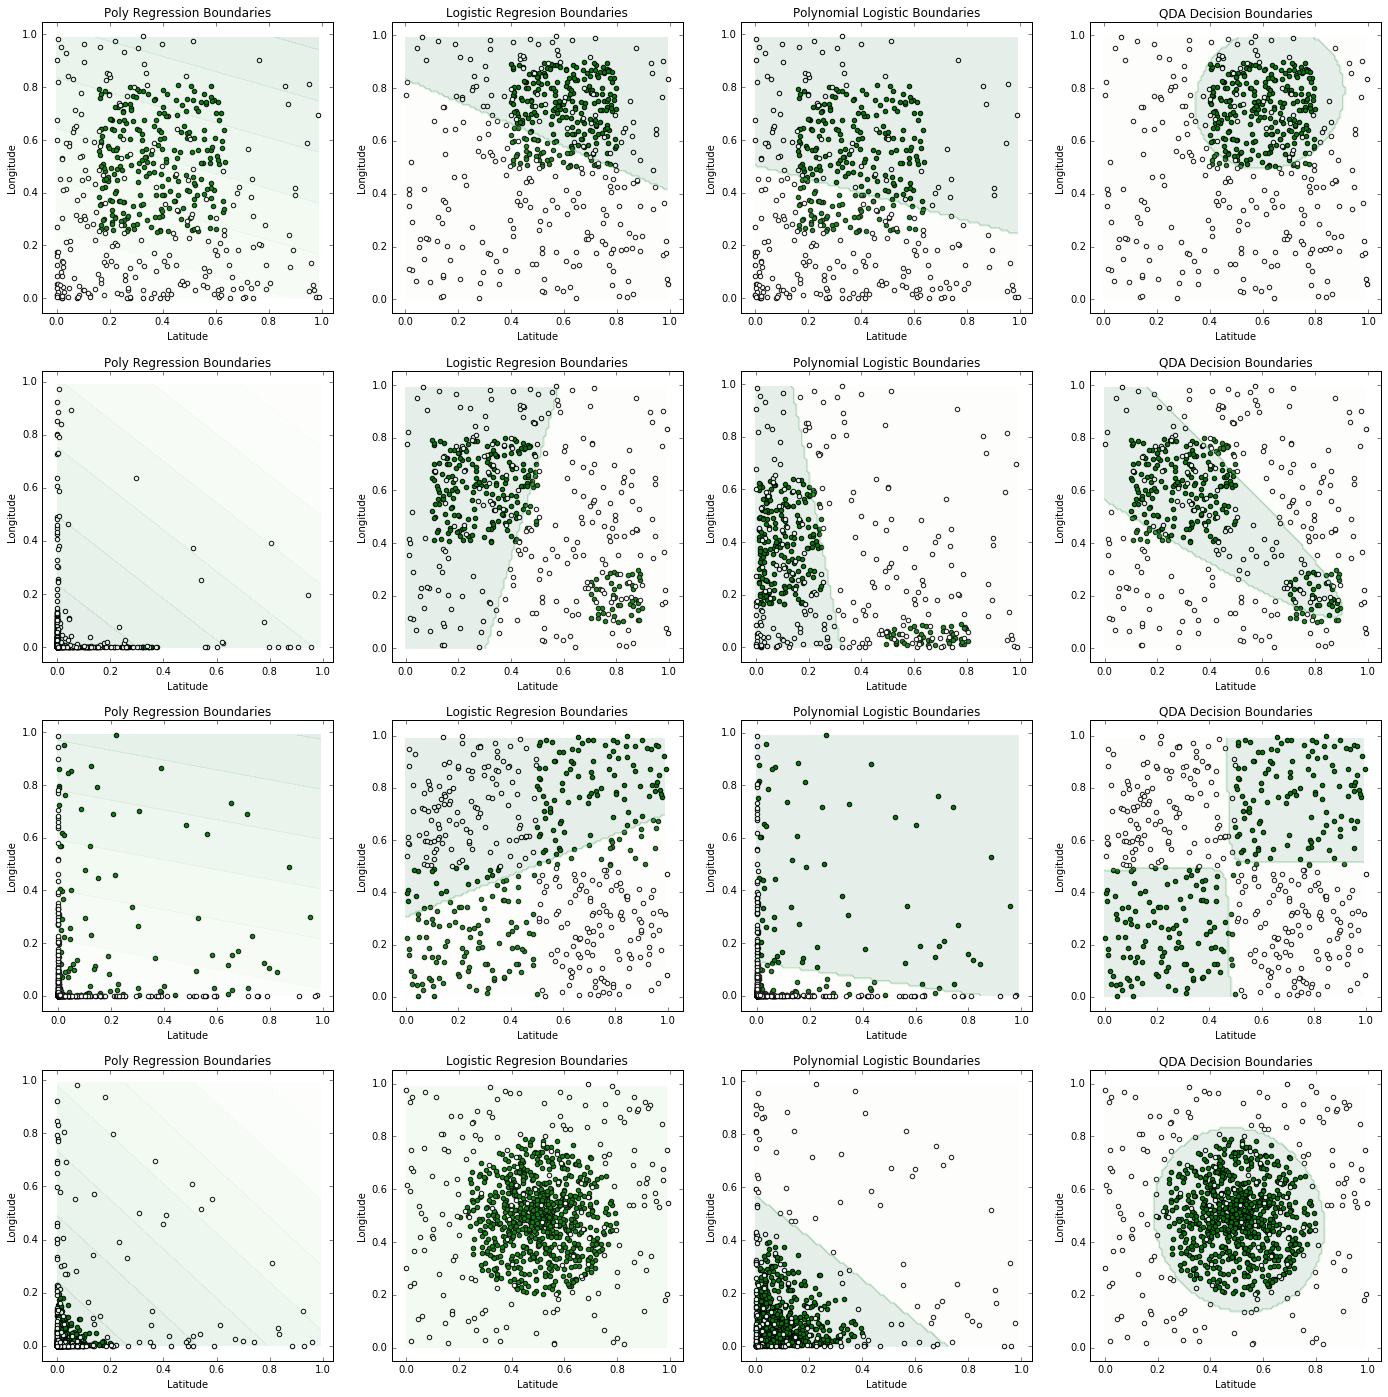

Scores for Dataset 1 are: 
----------------------------------------
Polynomial linear regression: 0.169 
Simple logisitc regression: 0.724 
Polynomial logistic regression: 0.684 
QDA: 0.87
----------------------------------------
Scores for Dataset 2 are: 
----------------------------------------
Polynomial linear regression: 0.084 
Simple logisitc regression: 0.664 
Polynomial logistic regression: 0.65 
QDA: 0.73
----------------------------------------
Scores for Dataset 3 are: 
----------------------------------------
Polynomial linear regression: 0.008 
Simple logisitc regression: 0.504 
Polynomial logistic regression: 0.544 
QDA: 0.962
----------------------------------------
Scores for Dataset 4 are: 
----------------------------------------
Polynomial linear regression: 0.265 
Simple logisitc regression: 0.8 
Polynomial logistic regression: 0.859 
QDA: 0.937
----------------------------------------


In [21]:
try_classifying(image_list)

## Exploring Trees

Okay, so polynomial linear regression is pretty bad, overall. Depending on what the data look like, simple and polynomial logistic regression look okay but not great, and QDA looks very good overall. But could we do better? I think, using trees, we can.

In [297]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [298]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

The way to classify in two dimensions using trees is pretty easy to do visually. Essentially, you need to ask "how few lines can I draw to get the classification right". 

 - The first dataset, you can see that 4 is probably the best number because it takes 4 lines to properly "box in" the vegetation points. 
 - For dataset 2, we'll need depth of 5 (root and 4 leaves for each main branch)
 - For dataset 3, we'll need 3 (root and 2 leaves for each main branch)
 - and for dataset 4, we'll do an okay job at maybe 6 but the more we add, the better we'll do. I think it will take a really large number of leaves to do as well as qda.
 
Let's Take a look...

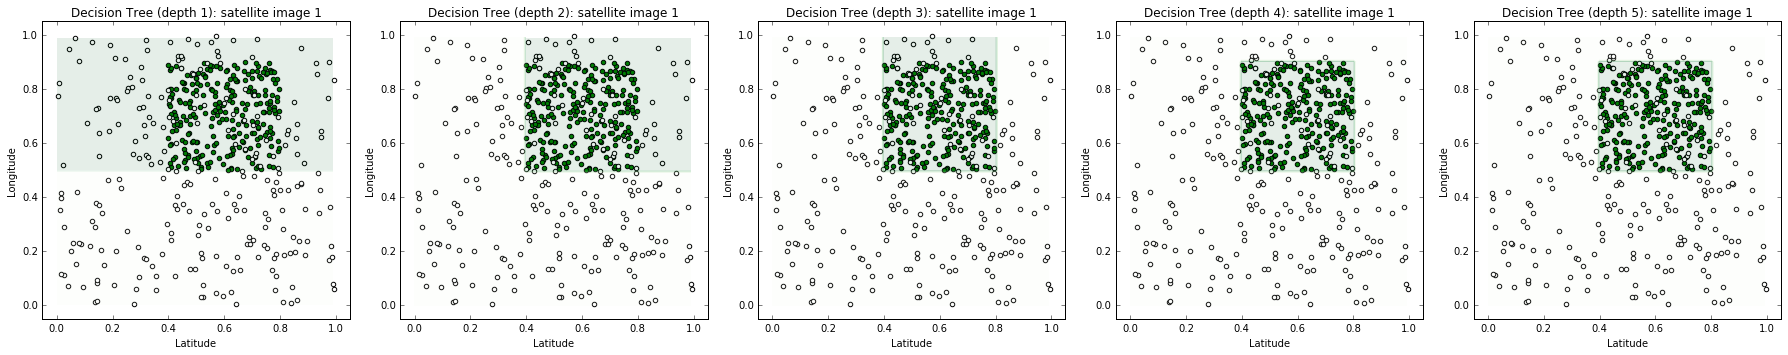

Tree Scores for Dataset 1 by depth are:
----------------------------------------
A tree of depth 1 is 0.774 percent accurate.
A tree of depth 2 is 0.868 percent accurate.
A tree of depth 3 is 0.9 percent accurate.
A tree of depth 4 is 0.928 percent accurate.
A tree of depth 5 is 0.928 percent accurate.


In [318]:
# Plot for dataset_1.txt: depths 1 to 5
fig3, ax3 = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = image_list[0].values[:, :-1]
#Get the class labels
y = image_list[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax3[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 1'.format(i), ax3[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

print "Tree Scores for Dataset 1 by depth are:" 
print "----------------------------------------"
for each in range(1, 6):
    dt = tree.DecisionTreeClassifier(max_depth = each)
    dt.fit(x, y)
    print "A tree of depth", each, "is", round(dt.score(x, y), 3), "percent accurate."

What we see here is that, at a certain point, creating additional depth in the tree doesn't get us anything as far as accuracy and just costs us computationally. In our case, for dataset 1, we only need 4 leaves.

Let's see the other 3.

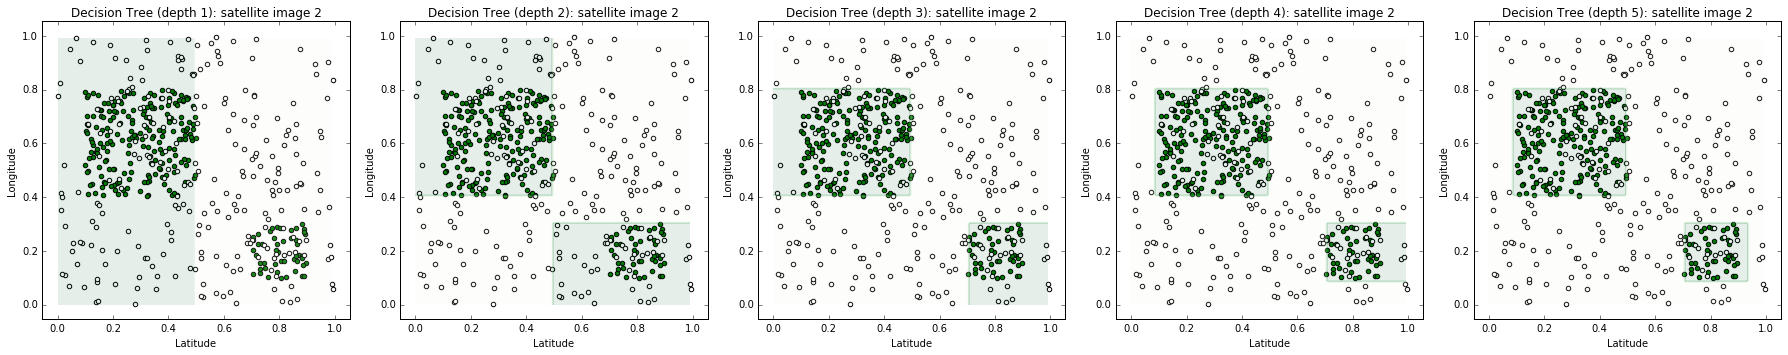

Tree Scores for Dataset 2 by depth are:
----------------------------------------
A tree of depth 1 is 0.658 percent accurate.
A tree of depth 2 is 0.76 percent accurate.
A tree of depth 3 is 0.852 percent accurate.
A tree of depth 4 is 0.874 percent accurate.
A tree of depth 5 is 0.88 percent accurate.


In [322]:
# Plot for dataset_1.txt: depths 1 to 5
fig3, ax3 = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = image_list[1].values[:, :-1]
#Get the class labels
y = image_list[1].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax3[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 2'.format(i), ax3[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

print "Tree Scores for Dataset 2 by depth are:" 
print "----------------------------------------"
for each in range(1, 6):
    dt = tree.DecisionTreeClassifier(max_depth = each)
    dt.fit(x, y)
    print "A tree of depth", each, "is", round(dt.score(x, y), 3), "percent accurate."

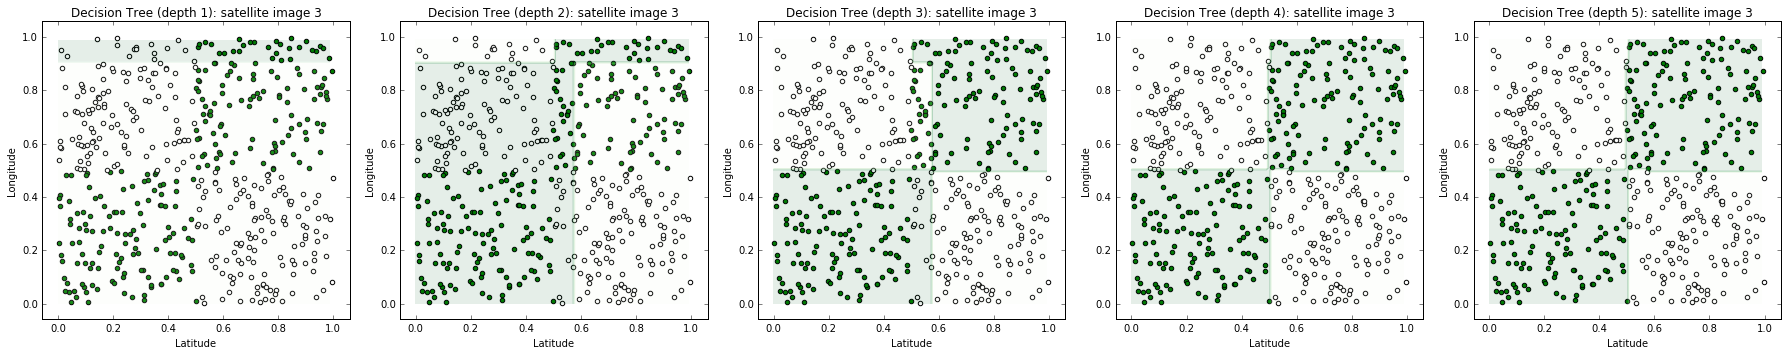

Tree Scores for Dataset 3 by depth are:
----------------------------------------
A tree of depth 1 is 0.532 percent accurate.
A tree of depth 2 is 0.62 percent accurate.
A tree of depth 3 is 0.932 percent accurate.
A tree of depth 4 is 1.0 percent accurate.
A tree of depth 5 is 1.0 percent accurate.


In [323]:
# Plot for dataset_1.txt: depths 1 to 5
fig3, ax3 = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = image_list[2].values[:, :-1]
#Get the class labels
y = image_list[2].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax3[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax3[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()


print "Tree Scores for Dataset 3 by depth are:" 
print "----------------------------------------"
for each in range(1, 6):
    dt = tree.DecisionTreeClassifier(max_depth = each)
    dt.fit(x, y)
    print "A tree of depth", each, "is", round(dt.score(x, y), 3), "percent accurate."

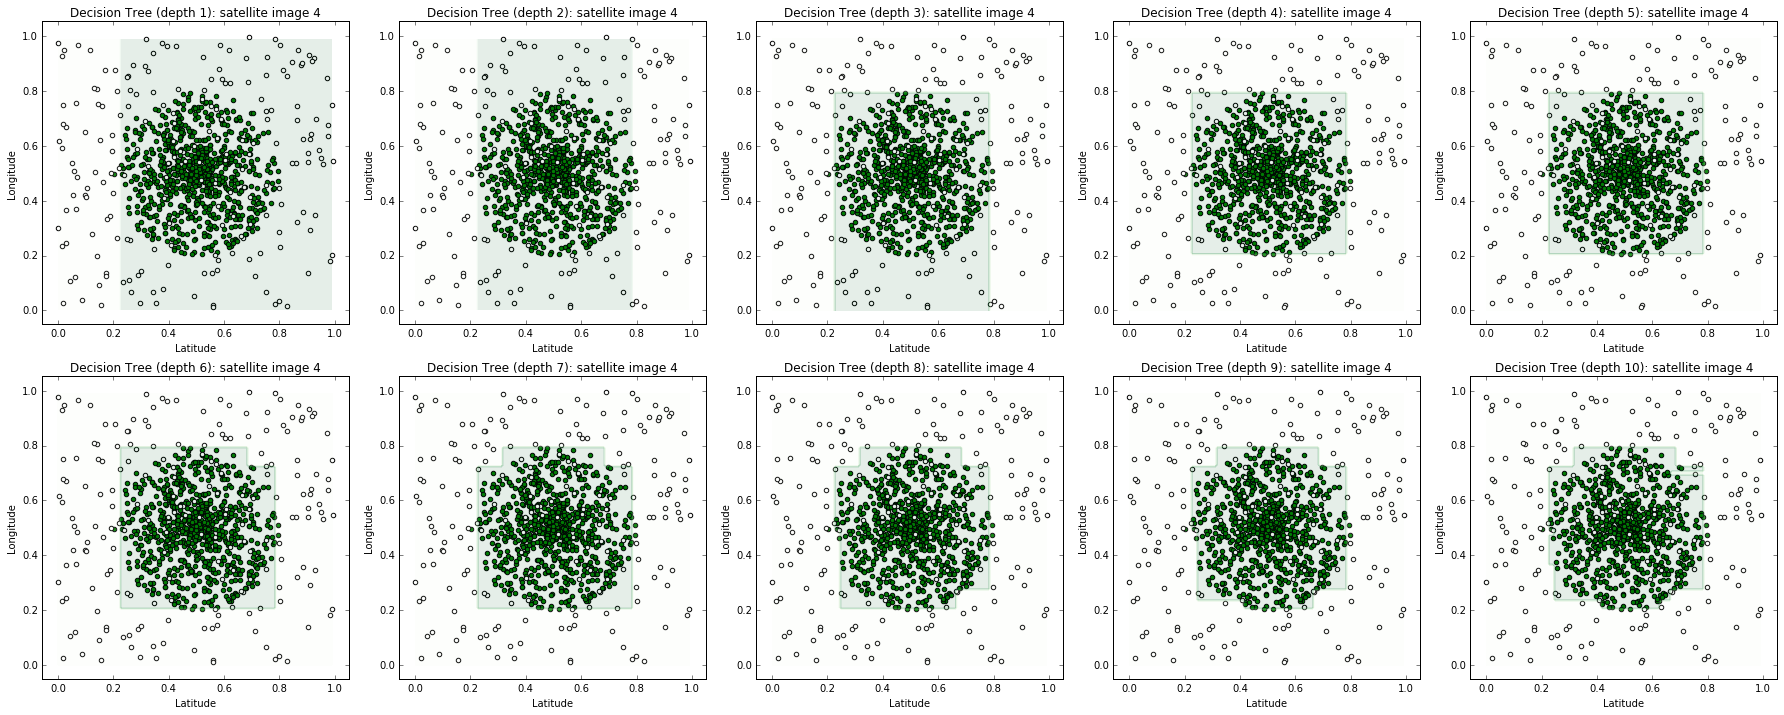

Tree Scores for Dataset 4 by depth are:
----------------------------------------
A tree of depth 1 is 0.852 percent accurate.
A tree of depth 2 is 0.894 percent accurate.
A tree of depth 3 is 0.922 percent accurate.
A tree of depth 4 is 0.945 percent accurate.
A tree of depth 5 is 0.945 percent accurate.
A tree of depth 6 is 0.948 percent accurate.
A tree of depth 7 is 0.953 percent accurate.
A tree of depth 8 is 0.957 percent accurate.
A tree of depth 9 is 0.959 percent accurate.
A tree of depth 10 is 0.964 percent accurate.


In [324]:
# Plot for dataset_1.txt: depths 1 to 5
fig3, ax3 = plt.subplots(2, 5, figsize=(25, 10))
#Get the long/lat coords
x = image_list[3].values[:, :-1]
#Get the class labels
y = image_list[3].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 11):
    #Plot data and decision boundary for decision tree model
    ax3[ind/5, ind%5] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 4'.format(i), ax3[ind/5, ind%5]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

print "Tree Scores for Dataset 4 by depth are:" 
print "----------------------------------------"
for each in range(1, 11):
    dt = tree.DecisionTreeClassifier(max_depth = each)
    dt.fit(x, y)
    print "A tree of depth", each, "is", round(dt.score(x, y), 3), "percent accurate."

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

In [122]:
# Calculate classification accuracy for a binary split
def err(x1, x2):
    return min((x1,x2))

# Calculate Gini coefficient for a binary split
def Gini(x1, x2):
    return x1*(1-x1) + x2*(1-x2)

# Calculate Cross-entropy for a binary split
def entropy(x1, x2):
    return -x1*math.log(x1) - x2*math.log(x2)

In [124]:
x1 = 23.0/100.0
x2 = 26.0/100.0

print err(x1, x2)
print Gini(x1, x2)
print entropy(x1, x2)

0.23
0.3695
0.688264621585


It looks like, in this case, that the first split might perform a little bit better on this data. We know, however, that the difference between the Gini coefficient and entropy are really quite marginal in most instances. When quantifying the impurity/information gain between two different classifiers, empirical studies have shown that the results are fairly consistent between the two criteria. The big difference is that gini is really designed for continuous vairables, and entropy is designed for classifiable data so that may be a good rule of thumb to use in the future; however, it doesn't seem to make a huge difference except in very particular circumstances.

## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 

- Interpret the way your model performs risk classifcation. Would you recommend this classifier to Unamed National Bank for making decisions on the loan applications of **real people**? If yes, make an argument for the merrits of this classifer. If no, then make necessary changes to the data set and fit a new classifier that you believe is fair to use in practice, then compare the two classifiers.


We have provided you with a function `display_dt` to display the structure of the decision tree in DOT format.

In [139]:
# Print decision tree model 'model', already fitted
def display_dt(model):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io) 
    print dummy_io.getvalue()

In [146]:
train = pd.read_csv('datasets/dataset_5_train.txt', delimiter=',', header=None)
test = pd.read_csv('datasets/dataset_5_test.txt', delimiter=',', header=None)

#Get our X Matrix
x_train = train.iloc[:, :-1]
x_test = test.iloc[:, :-1]

#Get the class labels
y_train = train.iloc[:, -1]
y_test = test.iloc[:, -1]

dt = tree.DecisionTreeClassifier(max_depth = 2)
dt.fit(x_train, y_train)
print "A tree of depth 2 is", round(dt.score(x_test, y_test), 3), "percent accurate."
display_dt(dt)

A tree of depth 2 is 0.881 percent accurate.
digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="X[2] <= 1.5\ngini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.2563\nsamples = 53\nvalue = [8, 45]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 58\nvalue = [0, 58]"] ;
1 -> 3 ;
4 [label="X[0] <= 3822.0\ngini = 0.295\nsamples = 139\nvalue = [114, 25]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.2159\nsamples = 130\nvalue = [114, 16]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 9\nvalue = [0, 9]"] ;
4 -> 6 ;
}


The splits in this case are X[0] (Census code) <= 3293, then the first leaf from that is X[2] (gender) <= 1.5 on one leaf, and X[0] (Census code) <= 3822 on the other.

What we see here is an algorithm that is 88% accurate. In the real world, when we're making decisions that will affect real people (their finances, credit, etc.), that is simply not good enough. Obviously, context is important, so in some circumstances, 88% might be good enough but in this case, I just don't see it as justifiable. Additionally, giving loans discriminating on the basis of gender is unlawful, I believe.

### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





In [419]:
n = len(x_train) #250
sub_size = n/10 #25
predictions_arr = np.empty([len(x_test), 503]) #250x500

#Create small sub-trees (bushes?) and make predictions
for each in range(500):
    perm = np.random.permutation(n)
    new_xtrain = x_train.iloc[perm[:sub_size]]
    new_ytrain = y_train.iloc[perm[:sub_size]]

    loop_tree = tree.DecisionTreeClassifier(max_depth = 2)
    loop_tree.fit(new_xtrain, new_ytrain)
    predictions = loop_tree.predict(x_test)
    predictions_arr[:, each] = predictions

#Set last column equal to actuals
predictions_arr[:, -1] = y_test

#Set our predictions (random and majority)
rand = []
ave = []
for each in range(len(predictions_arr)):
    rando = np.random.permutation(500)
    if predictions_arr[each, rando[0]] == predictions_arr[each, -1]:
        rand.append(1)
    else:
        rand.append(0)
    
    #This is cleverly rounding the average of the predictions down to 0 or up to 1 to represent our prediction
    ave.append(round(np.mean(predictions_arr[each, :]), 0))
    
predictions_arr[:, -3] = rand
predictions_arr[:, -2] = ave

#Score our predictors
randscore = []
avescore = []
for each in range(len(predictions_arr)):
    if predictions_arr[each, -3] == predictions_arr[each, -1]:
        randscore.append(1)
    else:
        randscore.append(0)
        
    if predictions_arr[each, -2] == predictions_arr[each, -1]:
        avescore.append(1)
    else:
        avescore.append(0)


print "Score for a randomly chosen classifier is:", round(np.mean(randscore), 3)
print "Score for a majority classifier is:", round(np.mean(avescore), 3)

Score for a randomly chosen classifier is: 0.505
Score for a majority classifier is: 0.863


Our randomly chosen classifier does't really perform any better than random guessing. This makes a lot of sense, because when our classifier is weak, we only really expect it to be right slightly better than half the time.

A majority classifier uses the power of the rule of large numbers - eventually, as we add more and more trials, the average result of the classifiers (no matter how weak... as long as they're A LITTLE better than random guessing) will get better and better.

In [418]:
n = len(x_train)/10

for i in range(1, 11):
# Take k-1 folds for training 
    x_first_half = x_train.iloc[:n * (i - 1), :]
    x_second_half = x_train.iloc[n * i + 1:, :]
    x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)

    y_first_half = y_train.iloc[:n * (i - 1)]
    y_second_half = y_train.iloc[n * i + 1:]
    y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)

    # Take the middle fold for testing
    x_test_cv = x_train.iloc[1 + n * (i - 1):n * i, :]
    y_test_cv = y_train.iloc[1 + n * (i - 1):n * i]
    
    scores = 0
    best_ind = 0
    scores_list = []
    best_ind_list = []
    for each in range(1, 16):
        RF_tree = ensemble.RandomForestClassifier(max_depth = each)
        RF_tree.fit(x_train_cv, y_train_cv)
        if round(RF_tree.score(x_test_cv, y_test_cv), 3) > (scores*1.03):
            scores = round(RF_tree.score(x_test_cv, y_test_cv), 3)
            best_ind = each
    
    RF_tree = ensemble.RandomForestClassifier(max_depth = best_ind)
    RF_tree.fit(x_train_cv, y_train_cv)
    scores_list.append(round(RF_tree.score(x_test_cv, y_test_cv), 3))
    best_ind_list.append(best_ind)
    
print "A Random Forest performs well at max depth", round(np.mean(best_ind_list), 0), ". It is", round(np.mean(scores_list), 3), "percent accurate."

A Random Forest performs well at max depth 3.0 . It is 0.917 percent accurate.


Using a Random Forest, we get some very good results. By building out an ensemble of full trees, then pruning back the bits that don't work for us, we get a fairly strong classifier.

## Challenge Problem: Boosting for Classification

We've seen in class that boosting is a useful ensemble method to combine a collection of simple regression trees into a powerful regression model. Chapter 10.1 of the text book ([*J.H. Friedman, R. Tibshirani, and T. Hastie, "The Elements of Statistical Learning"*](http://statweb.stanford.edu/~tibs/ElemStatLearn/)) describes the boosting technique for classification trees. Implement the method from scratch.
    
Write a function `fit_and_score_boosted_trees` satisfying:
- Input:
    - `x_train`:  Array of predictors in training set
    - `y_train`:  Array of binary responses in training set
    - `x_test`:  Array of predictors in training set
    - `y_test`:  Array of binary responses in training set
    - `M`:  Number of iterations / Number of decision trees in the ensemble
    - `depth`:  Depth of each decision tree
- Fits an ensemble of `T` decision trees to the training set
- Output:
    - `test_accuracy`:  classification accuracy of the ensemble on the test set

Your function will also have to **standardise** the predictors in the training and test sets before applying boosting.
   
**Hints:** 
- `sklearn`'s decision tree learning routine has an option to specific weights on the training points
- `sklearn`'s classifiers make predictions in {0,1} while the book assumes predictions in {-1, 1}

Your implementation will be evaluated based on three test cases: 

`challenge_testcase_1_train.txt`, `challenge_testcase_1_test.txt`

`challenge_testcase_2_train.txt`, `challenge_testcase_2_test.txt`

`challenge_testcase_3_train.txt`, `challenge_testcase_3_test.txt`

These cases represent extreme examples of data (each dataset contains a particular type of pathology) that might break an implementaiton that is not carefully thought through. 

**Run the code given below to test your implementation. Call `test_implementation` and pass it your function `fit_and_score_boosted_trees`.**

In [210]:
def fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, m, depth):
    # Step 0.5 - Clean data
    ## Seeing some bad data in testcase 2. I'm going to assume our instrument was broken and drop this regressor
    ## from the model.
    for i in range(x_train.shape[1]):
        if not np.any(x_train[:, i]):
            x_train = x_train[:, :-1]
            x_test = x_test[:, :-1]
    
    # Step 1 - initialize our weights vector
    weights = np.full(len(x_train), 1/float(len(x_train)))
    
    for iterations in range(m):
        
        # Step 2 - standardize data
        for each in range(x_train.shape[1]):
            mean = np.mean(x_train[:, each])
            stdev = np.std(x_train[:, each])
            x_train[:, each] = (x_train[:, each]-mean) / stdev

        # Step 3 - fit a tree 
        boost_tree = tree.DecisionTreeClassifier(max_depth = depth)
        boost_tree.fit(x_train, y_train, sample_weight = weights)

        # Step 4 - determine the error score
        predict = boost_tree.predict(x_train)
        error_list = []
        for i in range(len(predict)):
            if predict[i] == y_train[i]:
                error_list.append(0.0)
            else:
                error_list.append(1.0)
        error = (np.sum(weights*error_list))/sum(weights)
    
        # Step 5 - determine alpha
        alpha = math.log((1-error)/error)
        
        # Step 6 - update weights vector
        for i in range(len(error_list)):
            weights[i] = weights[i] * math.exp(alpha * error_list[i])
                
    test_accuracy = boost_tree.score(x_test, y_test)
    
    return test_accuracy

In [217]:
#--------  test_implementation
# A function that tests your fit_and_score_boosted_trees function using three test sets.
# Input: 
#      fit_and_score_boosted_trees (your implementation of the boosting function)
# Returns: 
#      None

def test_implementation(fit_and_score_boosted_trees):
    
    # Iterate over test cases
    for i in range(1,4):
        # Load train & test data
        data_train = np.loadtxt('datasets/challenge_testcase_' + str(i) + '_train.txt', delimiter=',')
        data_test = np.loadtxt('datasets/challenge_testcase_' + str(i) + '_test.txt', delimiter=',')

        # Split label and instances
        y_train = data_train[:,-1]
        x_train = data_train[:,0:-1]

        y_test = data_test[:,-1]
        x_test = data_test[:,0:-1]

        # Run boosting function
        custom_score = fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, 10, 2) 
        print 'Test case', i, ':\nCustom Boost function scores:', custom_score
        
        sklearnboost = ensemble.AdaBoostClassifier()
        propertree = sklearnboost.fit(x_train, y_train)
        print "SkLearn AdaBoost scores:", propertree.score(x_test, y_test), "\n"

In [218]:
test_implementation(fit_and_score_boosted_trees)

Test case 1 :
Custom Boost function scores: 0.505025641026
SkLearn AdaBoost scores: 0.504923076923 

Test case 2 :
Custom Boost function scores: 0.505025641026
SkLearn AdaBoost scores: 0.500615384615 

Test case 3 :
Custom Boost function scores: 0.505025641026
SkLearn AdaBoost scores: 0.504923076923 

